# **Step 0：ライブラリの読み込み**

In [1]:
!pip install rdkit

In [2]:
import rdkit
from rdkit import rdBase, Chem, DataStructs
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors, PandasTools
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem import AllChem, Draw
from copy import deepcopy
import numpy as np
import pandas as pd
from numpy import vectorize as vec
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
print(rdBase.rdkitVersion)

2023.09.1


# **Step 1：SDFファイルの読み込み**

In [3]:
# MDLフォーマットのファイル(nr-ar.sdf)を読み込む
# 読み込めない化合物もある（本当は事前に確認して削っておくべき）
# nr-ar.sdfはこちらから取得できます。 https://github.com/hatanaka-lab/Getting_started_with_MI/blob/main/data/nr-ar.sdf
# データの元ネタはこちら：https://tripod.nih.gov/tox21/challenge/
df_mols=PandasTools.LoadSDF('nr-ar.sdf',smilesName='SMILES',molColName='Mol_Object',includeFingerprints=True)

[02:58:19] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 1 ignored.
[02:58:19] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 6 ignored.
[02:58:22] Explicit valence for atom # 2 Si, 8, is greater than permitted
[02:58:22] ERROR: Could not sanitize molecule ending on line 153869
[02:58:22] ERROR: Explicit valence for atom # 2 Si, 8, is greater than permitted
[02:58:26] Explicit valence for atom # 3 Cl, 2, is greater than permitted
[02:58:26] ERROR: Could not sanitize molecule ending on line 223779
[02:58:26] ERROR: Explicit valence for atom # 3 Cl, 2, is greater than permitted
[02:58:31] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[02:58:31] ERROR: Could not sanitize molecule ending on line 339188
[02:58:31] ERROR: Explicit valence for atom # 1 Cl, 2, is greater than permitted
[02:58:32] WARNING: not removing hydrogen atom without neighbors
[02:58:35] Explicit valence for atom # 2 Si, 8, is gre

In [4]:
#molsの中身を確認①項目
df_mols.columns

Index(['Formula', 'FW', 'DSSTox_CID', 'Active', 'ID', 'SMILES', 'Mol_Object'], dtype='object')

In [5]:
#molsの中身を確認②データ数
df_mols.shape

(9358, 7)

In [6]:
#molsの中身を確認③active/inactiveの化合物数
print("Num of active mols: ", list(df_mols.Active).count('1'))
print("Num of inactive mols: ", list(df_mols.Active).count('0'))

Num of active mols:  380
Num of inactive mols:  8978


,Formula,FW,DSSTox_CID,Active,ID,SMILES,Mol_Object
0,C66H87N17O14,1342.5025 (1282.4505+60.0520),26683,0,NCGC00167516-01,CC(=O)O.CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=...,
1,C25H39ClN2O,419.0430 (382.5820+36.4609),26837,0,NCGC00181091-01,CCCCCCOc1ccc(C(=N)N(CCCC)CCCC)c2ccccc12.Cl,
2,C29H40Cl2FN3O3,568.5506 (495.6287+36.4609+36.4609),24204,0,NCGC00094089-01,COCC(=O)O[C@]1(CCN(C)CCCc2nc3ccccc3[nH]2)CCc2c...,
3,C26H58Cl2N10,581.7117 (508.7898+36.4609+36.4609),25881,0,NCGC00094996-01,CCCCC(CC)CNC(=N)NC(=N)NCCCCCCNC(=N)NC(=N)NCC(C...,
4,C22H40BrNO,414.4631 (334.5586+79.9045),13468,0,NCGC00257773-01,CCCCCCCCCCCC[N+](C)(C)CCOc1ccccc1.[Br-],
...,...,...,...,...,...,...,...
9357,C7H10N2OS,170.2321,1209,0,NCGC00259290-01,CCCc1cc(=O)[nH]c(=S)[nH]1,
9358,C3H6N2S,102.1581,601,0,NCGC00258846-01,S=C1NCCN1,
9359,C3H6N2S,102.1581,601,0,NCGC00254936-01,S=C1NCCN1,
9360,C10H14NO5PS,291.2606,1100,0,NCGC00254571-01,CCOP(=S)(OCC)Oc1ccc([N+](=O)[O-])cc1,

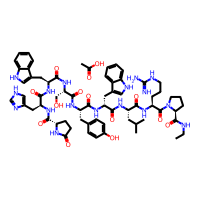
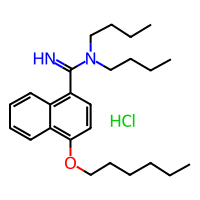
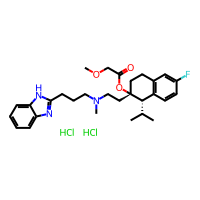
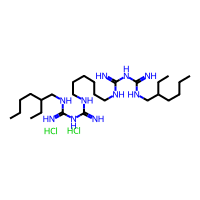
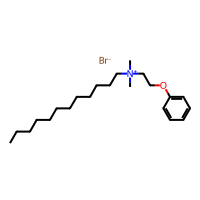
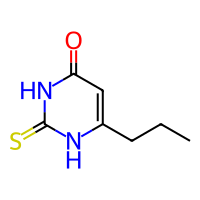
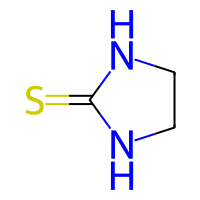
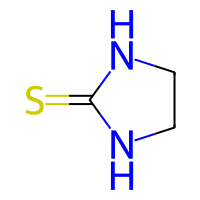
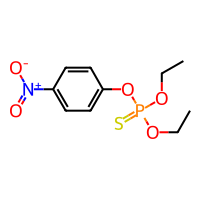
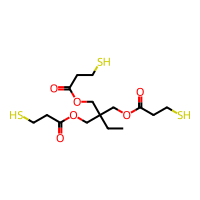

In [7]:
#molsの中身を確認④
df_mols

# **Step2：RDKitを用いた特徴量(記述子)への変換**

In [8]:
#rdkitの機能で算出可能な記述子の一覧
names = [x[0] for x in Descriptors._descList]
print("Number of descriptors in the rdkit: ", len(names))
np.array(names)

Number of descriptors in the rdkit:  211


array(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt',
       'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons',
       'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge',
       'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2',
       'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI',
       'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI',
       'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n',
       'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n',
       'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1',
       'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10',
       'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14',
       'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6',
       'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10',
       'SMR_VSA2', 'SMR_VSA3',

In [9]:
# 本当は上記の記述子を全部使いたいけれど…
# ここでは練習のため、一部を(適当に)pick up
df_mols_feat = deepcopy(df_mols)
for desc in ['TPSA','MaxPartialCharge','SlogP_VSA1','EState_VSA1','SMR_VSA1','MolLogP','MolMR','BalabanJ','HallKierAlpha','Kappa1','Kappa2','Kappa3','RingCount','NumHAcceptors','NumHDonors']:
    exec("df_mols_feat[desc]=vec(Descriptors.{})(df_mols_feat['Mol_Object'])".format(desc))
print("shape of data : {}".format(df_mols_feat.shape))
df_mols_feat

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2411: RuntimeWarning: divide by zero encountered in MaxPartialCharge (vectorized)
  outputs = ufunc(*inputs)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in MaxPartialCharge (vectorized)
  outputs = ufunc(*inputs)


shape of data : (9358, 22)


,Formula,FW,DSSTox_CID,Active,ID,SMILES,Mol_Object,TPSA,MaxPartialCharge,SlogP_VSA1,...,MolLogP,MolMR,BalabanJ,HallKierAlpha,Kappa1,Kappa2,Kappa3,RingCount,NumHAcceptors,NumHDonors
0,C66H87N17O14,1342.5025 (1282.4505+60.0520),26683,0,NCGC00167516-01,CC(=O)O.CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=...,<rdkit.Chem.rdchem.Mol object at 0x7c818954c350>,482.13,0.299685,58.901554,...,-0.45963,355.2076,0.000003,-10.85,73.558677,35.596275,21.584998,8,15,18
1,C25H39ClN2O,419.0430 (382.5820+36.4609),26837,0,NCGC00181091-01,CCCCCCOc1ccc(C(=N)N(CCCC)CCCC)c2ccccc12.Cl,<rdkit.Chem.rdchem.Mol object at 0x7c818954c430>,36.32,0.128188,4.736863,...,7.44827,129.0507,0.000004,-1.74,25.296684,14.275348,7.544791,2,2,1
2,C29H40Cl2FN3O3,568.5506 (495.6287+36.4609+36.4609),24204,0,NCGC00094089-01,COCC(=O)O[C@]1(CCN(C)CCCc2nc3ccccc3[nH]2)CCc2c...,<rdkit.Chem.rdchem.Mol object at 0x7c818954c510>,67.45,0.332137,0.000000,...,6.11450,154.0237,0.000003,-2.19,32.024380,14.267965,7.468310,4,5,1
3,C26H58Cl2N10,581.7117 (508.7898+36.4609+36.4609),25881,0,NCGC00094996-01,CCCCC(CC)CNC(=N)NC(=N)NCCCCCCNC(=N)NC(=N)NCC(C...,<rdkit.Chem.rdchem.Mol object at 0x7c818954c5f0>,167.58,0.194749,31.900732,...,5.09988,168.7650,-0.000006,-1.94,40.554948,28.077836,24.399777,0,4,10
4,C22H40BrNO,414.4631 (334.5586+79.9045),13468,0,NCGC00257773-01,CCCCCCCCCCCC[N+](C)(C)CCOc1ccccc1.[Br-],<rdkit.Chem.rdchem.Mol object at 0x7c818954c740>,9.23,0.137062,21.718314,...,3.06670,105.6234,0.000006,-0.54,24.460000,15.694462,14.328027,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9357,C7H10N2OS,170.2321,1209,0,NCGC00259290-01,CCCc1cc(=O)[nH]c(=S)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7c818879c820>,48.65,0.251361,5.559267,...,1.38499,46.2424,3.088124,-0.90,8.199010,3.479115,2.307384,1,2,2
9358,C3H6N2S,102.1581,601,0,NCGC00258846-01,S=C1NCCN1,<rdkit.Chem.rdchem.Mol object at 0x7c818879c900>,24.06,0.165918,10.633577,...,-0.53590,28.6034,2.367352,-0.31,3.865747,1.426834,0.596594,1,1,2
9359,C3H6N2S,102.1581,601,0,NCGC00254936-01,S=C1NCCN1,<rdkit.Chem.rdchem.Mol object at 0x7c818879c9e0>,24.06,0.165918,10.633577,...,-0.53590,28.6034,2.367352,-0.31,3.865747,1.426834,0.596594,1,1,2
9360,C10H14NO5PS,291.2606,1100,0,NCGC00254571-01,CCOP(=S)(OCC)Oc1ccc([N+](=O)[O-])cc1,<rdkit.Chem.rdchem.Mol object at 0x7c818879cac0>,70.83,0.380045,4.523747,...,3.27110,71.2614,2.809299,-1.01,15.048858,6.797885,4.343347,1,6,0


# **Step3：欠損データの確認**

In [10]:
# 特徴量の中に欠損データがある場合は"True"と表示される → 説明変数から外す
print(df_mols_feat.isnull().any())

Formula             False
FW                  False
DSSTox_CID          False
Active              False
ID                  False
SMILES              False
Mol_Object          False
TPSA                False
MaxPartialCharge     True
SlogP_VSA1          False
EState_VSA1         False
SMR_VSA1            False
MolLogP             False
MolMR               False
BalabanJ            False
HallKierAlpha       False
Kappa1              False
Kappa2              False
Kappa3              False
RingCount           False
NumHAcceptors       False
NumHDonors          False
dtype: bool


In [11]:
# 欠損データを含む特徴量(MaxPartialCharge)や、数値以外のデータを含む列(Formula, FW,…,Molecule)、目的変数(Active)を外して、再度説明変数を定義
df_mols_feat=df_mols_feat.drop(["MaxPartialCharge", "Formula", "FW", "DSSTox_CID", "ID", "SMILES", "Mol_Object", "Active"], axis=1)

In [12]:
# 再度特徴量に欠損データがないか確認（確認方法①）
print(df_mols_feat.isnull().any())

TPSA             False
SlogP_VSA1       False
EState_VSA1      False
SMR_VSA1         False
MolLogP          False
MolMR            False
BalabanJ         False
HallKierAlpha    False
Kappa1           False
Kappa2           False
Kappa3           False
RingCount        False
NumHAcceptors    False
NumHDonors       False
dtype: bool


In [13]:
# 再度特徴量に欠損データがないか確認（確認方法②）
print(df_mols_feat.isnull().sum())

TPSA             0
SlogP_VSA1       0
EState_VSA1      0
SMR_VSA1         0
MolLogP          0
MolMR            0
BalabanJ         0
HallKierAlpha    0
Kappa1           0
Kappa2           0
Kappa3           0
RingCount        0
NumHAcceptors    0
NumHDonors       0
dtype: int64


In [14]:
# 最終的に残った特徴量を表示
df_mols_feat

,TPSA,SlogP_VSA1,EState_VSA1,SMR_VSA1,MolLogP,MolMR,BalabanJ,HallKierAlpha,Kappa1,Kappa2,Kappa3,RingCount,NumHAcceptors,NumHDonors
0,482.13,58.901554,114.210193,68.059491,-0.45963,355.2076,0.000003,-10.85,73.558677,35.596275,21.584998,8,15,18
1,36.32,4.736863,0.000000,4.736863,7.44827,129.0507,0.000004,-1.74,25.296684,14.275348,7.544791,2,2,1
2,67.45,0.000000,5.601051,18.658678,6.11450,154.0237,0.000003,-2.19,32.024380,14.267965,7.468310,4,5,1
3,167.58,31.900732,0.000000,0.000000,5.09988,168.7650,-0.000006,-1.94,40.554948,28.077836,24.399777,0,4,10
4,9.23,21.718314,0.000000,26.201345,3.06670,105.6234,0.000006,-0.54,24.460000,15.694462,14.328027,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9357,48.65,5.559267,0.000000,0.000000,1.38499,46.2424,3.088124,-0.90,8.199010,3.479115,2.307384,1,2,2
9358,24.06,10.633577,0.000000,0.000000,-0.53590,28.6034,2.367352,-0.31,3.865747,1.426834,0.596594,1,1,2
9359,24.06,10.633577,0.000000,0.000000,-0.53590,28.6034,2.367352,-0.31,3.865747,1.426834,0.596594,1,1,2
9360,70.83,4.523747,11.641918,18.494553,3.27110,71.2614,2.809299,-1.01,15.048858,6.797885,4.343347,1,6,0


In [15]:
#　説明変数を標準化する
#　標準化された値 = (元の値－平均値)/標準偏差
#  ここではRandom Forest Classiferを用いるので標準化しなくても良い
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(df_mols_feat)

# **Step4：データを観察**

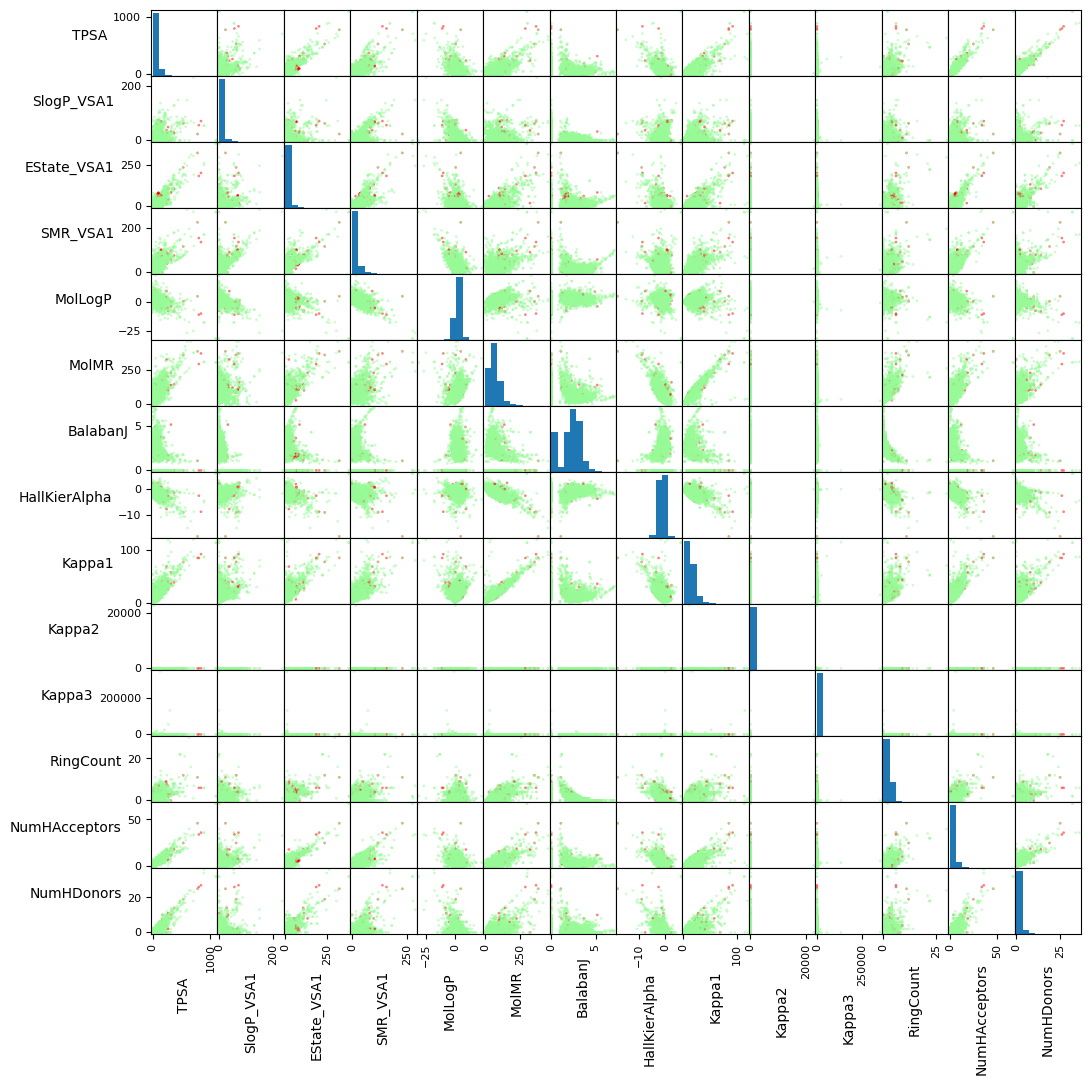

In [16]:
# データの分布を観察する：その1（説明変数間の散布図）
def set_color(L):
    O = []
    for l in L:
        if l == '1':
            O.append("red")
        else:
            O.append("palegreen")
    return O

axes = pd.plotting.scatter_matrix(df_mols_feat, figsize=(12,12), hist_kwds={'bins':10},
                           marker='.', s=15, alpha=.5, c=set_color(df_mols.Active))
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
plt.show()

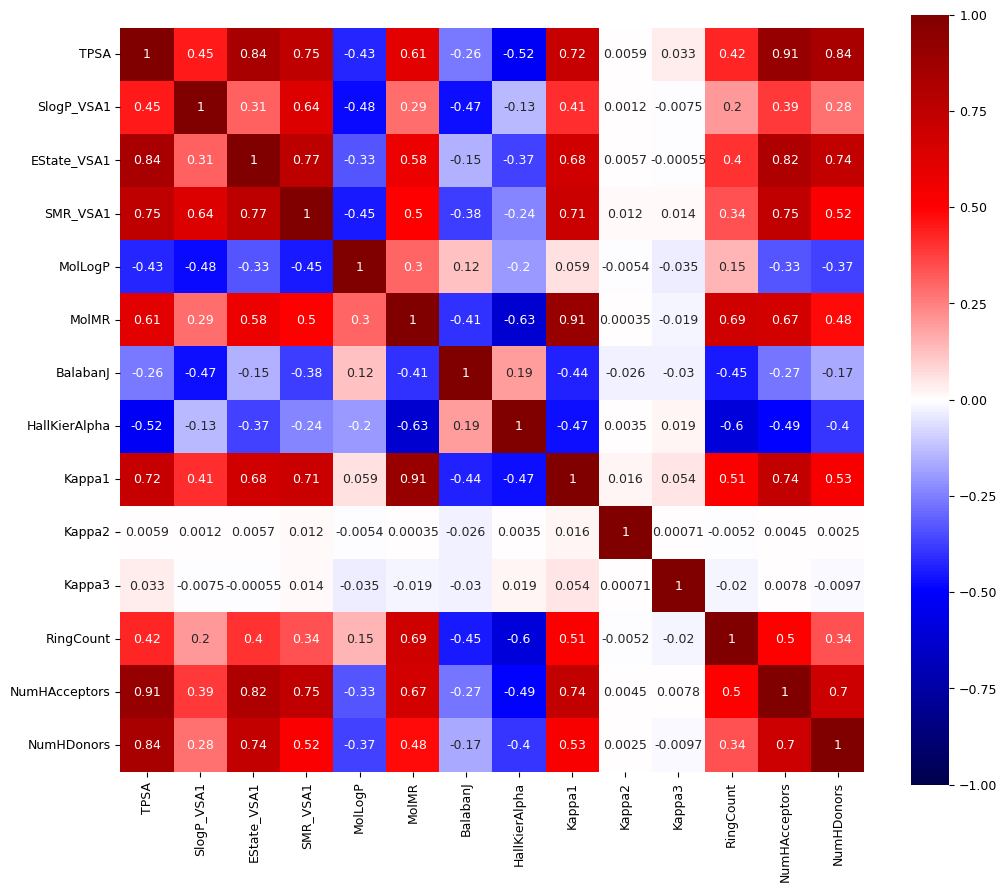

In [17]:
# データの分布を観察する：その2（相関行列）
correlation_coefficients = df_mols_feat.corr()  # 相関行列の計算
# 相関行列のヒートマップ (相関係数の値あり)
plt.rcParams['font.size'] = 9
plt.figure(figsize=(12, 10))  # この段階で画像のサイズを指定する
sns.heatmap(correlation_coefficients, vmax=1, vmin=-1, cmap='seismic', square=True, annot=True, xticklabels=1, yticklabels=1)
plt.xlim([0, correlation_coefficients.shape[0]])
plt.show()

# **Step5：データを分割（交差検証用）**

In [18]:
# データを訓練用・テスト用に分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_mols_feat, df_mols.Active, train_size=0.75, test_size=0.25, random_state=10)

In [19]:
# 分割したデータの個数を確認
print("Training Data -------------")
print(" Number of   active molecules:  ", list(y_train).count('1'))
print(" Number of inactive molecules:  ", list(y_train).count('0'))
print("Test Data -----------------")
print(" Number of   active molecules:  ", list(y_test).count('1'))
print(" Number of inactive molecules:  ", list(y_test).count('0'))

Training Data -------------
 Number of   active molecules:   275
 Number of inactive molecules:   6743
Test Data -----------------
 Number of   active molecules:   105
 Number of inactive molecules:   2235


## **Step6：ハイパーパラメタの決定**

In [20]:
# Random Forest Classifier(RFC)用にハイパーパラメタを決める
# RFCの各パラメータの意味はこちらを参照
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
list_param = []
list_score = []
for ne in range(50,250,50):
  for nd in [5, 10, 25, 50, 100]:
    model = RandomForestClassifier(n_estimators=ne, max_depth=nd, random_state=111)
    cv5_score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()  #訓練用データ(train)を用いて5-fold CV
    print("num_trees=",ne,", max_depth=",nd," , Accuracy=",cv5_score)
    list_param.append([ne,nd])
    list_score.append(cv5_score)
max_index = np.argmax(list_score)
print("")
print("-----Best parameters-----")
print("num_trees=",list_param[max_index][0], "max_depth=",list_param[max_index][1],"Accuracy=",list_score[max_index])

num_trees= 50 , max_depth= 5  , Accuracy= 0.9719294023998228
num_trees= 50 , max_depth= 10  , Accuracy= 0.9766314754910621
num_trees= 50 , max_depth= 25  , Accuracy= 0.9754915697538648
num_trees= 50 , max_depth= 50  , Accuracy= 0.9754915697538648
num_trees= 50 , max_depth= 100  , Accuracy= 0.9754915697538648
num_trees= 100 , max_depth= 5  , Accuracy= 0.97292685799457
num_trees= 100 , max_depth= 10  , Accuracy= 0.9764890253486118
num_trees= 100 , max_depth= 25  , Accuracy= 0.9760614718561975
num_trees= 100 , max_depth= 50  , Accuracy= 0.9760614718561975
num_trees= 100 , max_depth= 100  , Accuracy= 0.9760614718561975
num_trees= 150 , max_depth= 5  , Accuracy= 0.9722144042172551
num_trees= 150 , max_depth= 10  , Accuracy= 0.9769164773084944
num_trees= 150 , max_depth= 25  , Accuracy= 0.9762041250637117
num_trees= 150 , max_depth= 50  , Accuracy= 0.9763465752061619
num_trees= 150 , max_depth= 100  , Accuracy= 0.9763465752061619
num_trees= 200 , max_depth= 5  , Accuracy= 0.9722144042172551


# **Step7：機械学習実行**

In [21]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=list_param[max_index][0], max_depth=list_param[max_index][1], random_state=111)
model.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
print("Accuracy on test set:     {:.3f}".format(model.score(X_test,  y_test)))

Accuracy on training set: 0.985
Accuracy on test set:     0.976


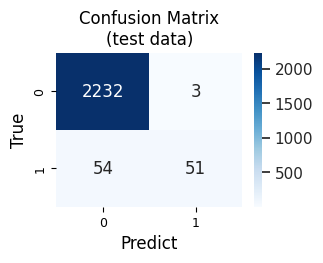

In [22]:
from sklearn.metrics import auc, accuracy_score, f1_score, confusion_matrix, log_loss, roc_auc_score
plt.figure(figsize=(3,2))
cm = confusion_matrix(y_test, model.predict(X_test))
ax = plt.subplot()
sns.set()
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");

# Labels, title and ticks
label_font = {'size':'12'}  # Adjust to fit
ax.set_xlabel('Predict', fontdict=label_font);
ax.set_ylabel('True',  fontdict=label_font);

title_font = {'size':'12'}  # Adjust to fit
ax.set_title('Confusion Matrix\n(test data)', fontdict=title_font);

#ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit

(Remind： Active = 1, Inactive = 0)

In [23]:
# Random Forest回帰モデルの特徴量重要度を解析
# まずは表形式（DataFrame型）で出力
model_importances = pd.DataFrame({"importance": model.feature_importances_}, index=X_train.columns)
# 重要度ごとの降順にして表示
model_importances_sorted = model_importances.sort_values(by="importance", ascending=False)
model_importances_sorted

,importance
Kappa3,0.132374
HallKierAlpha,0.096843
RingCount,0.095043
BalabanJ,0.090192
MolMR,0.082164
SlogP_VSA1,0.080512
Kappa2,0.077728
Kappa1,0.073622
MolLogP,0.063254
SMR_VSA1,0.062402


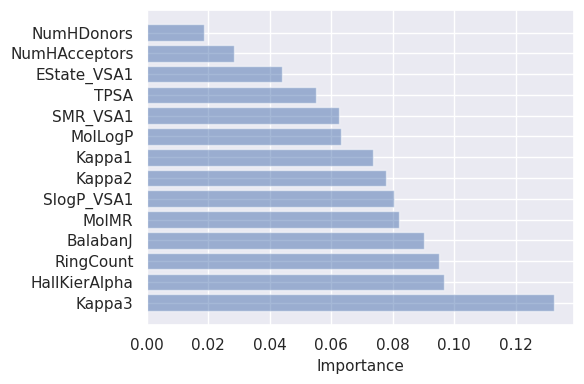

In [24]:
# 棒グラフで重要度を図示
fig, ax = plt.subplots(figsize=(6,4))
y_pos = np.arange(model_importances_sorted.shape[0])
list_importances = list(model_importances_sorted["importance"])
ax.barh(y_pos, list_importances, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_yticks(y_pos)
ax.set_yticklabels(model_importances_sorted.index)
label_imp_font = {'size':'11'}
title_imp_font = {'size':'12'}
ax.set_xlabel('Importance', fontdict=label_imp_font)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

# **補足：分子情報がSMILESで与えられている場合**

分子の通し番号(ID), SMILES, 物性値(DATA)をまとめたcsvファイルを読み込みます。

ファイルはこちら：https://github.com/hatanaka-lab/Getting_started_with_MI/blob/main/data/smiles_data.csv

上記のSDFファイル由来のデータと混ざらないように、オブジェクト名をmols_2にしました。分子数が多いので、計算に時間がかかります。csvファイルの行数を適当に減らしてテスト計算してみても良いです。

In [25]:
# csvファイルの中身をpandasのdata frameに格納
df_mols2 = pd.read_csv("smiles_data.csv")
df_mols2.head(4)

,ID,SMILES,DATA
0,1,CC1=CC(=O)C=CC1=O,5.5705
1,2,CCCCCCCCCCCCCCCc1cc(ccc1N)O,7.3320
2,3,c1ccc(cc1)C(CCI)(c2ccccc2)c3ccccc3,5.4490
3,4,CN(C)CCC(=O)c1ccccc1,4.6310


物性値が連続値であるため、回帰モデルを構築することも可能ですが、

ここでは、DATA>6をActive、DATA<=6をInactiveとする二値分類問題として扱います。

In [26]:
# mol_2に'Active'という列を追加し、Active/Inactiveの情報を書き込む
# やり方①：Active/Inactiveを1/0として書き込む
df_mols2['Active'] = [1 if mol > 6 else 0 for mol in df_mols2['DATA']]

# やり方②：Active/InactiveをTrue/Falseとして書き込む
# df_mols2['Active'] = df_mols2['DATA'] > 6

df_mols2.head(3)

,ID,SMILES,DATA,Active
0,1,CC1=CC(=O)C=CC1=O,5.5705,0
1,2,CCCCCCCCCCCCCCCc1cc(ccc1N)O,7.3320,1
2,3,c1ccc(cc1)C(CCI)(c2ccccc2)c3ccccc3,5.4490,0


In [27]:
Chem.PandasTools.AddMoleculeColumnToFrame(df_mols2, smilesCol='SMILES', molCol='Mol_Object')

In [28]:
print("Number of   active molecules:  ", list(df_mols2.Active).count(1))  #Active
print("Number of inactive molecules:  ", list(df_mols2.Active).count(0))  #Inactive

Number of   active molecules:   468
Number of inactive molecules:   2374


,ID,SMILES,DATA,Active,Mol_Object
0,1,CC1=CC(=O)C=CC1=O,5.5705,0,
1,2,CCCCCCCCCCCCCCCc1cc(ccc1N)O,7.3320,1,
2,3,c1ccc(cc1)C(CCI)(c2ccccc2)c3ccccc3,5.4490,0,
3,4,CN(C)CCC(=O)c1ccccc1,4.6310,0,
4,5,Cc1cc(c(c(c1C)C)C[N+](C)(C)C)C,6.6960,1,
...,...,...,...,...,...
2837,2838,CCCCc1c(c2ccccc2o1)C(=O)c3cc(c(c(c3)I)OCCN(CC)...,5.3430,0,
2838,2839,CCC1=C(C(Oc2c1ccc(c2CN3CCCC3)O)(C)C)c4ccc(cc4)OC,5.7310,0,
2839,2840,c1cc(c(c(c1CN2CCOCC2)O)O)CN3CCOCC3,5.4410,0,
2840,2841,CCCCCCCCCCCC[N+](C)(C)Cc1ccccc1,5.7260,0,

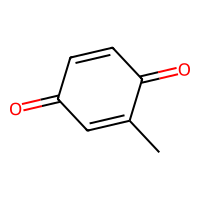
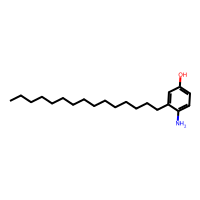
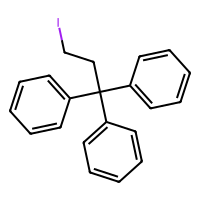
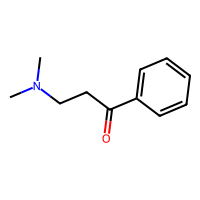
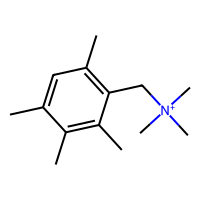
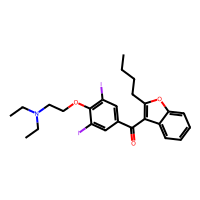
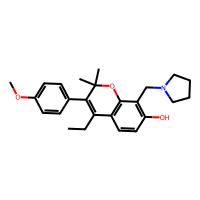
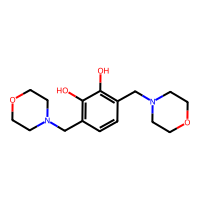
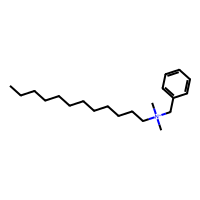
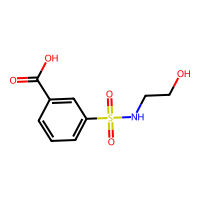

In [29]:
# df_mols2の中身を確認
df_mols2

In [30]:
#あとは上記と同じようにRdkitを使って記述子に変換
#今回は全部使用する
# molオブジェクトから特徴量への変換を行う計算モジュール(MoleculeDescriptors.MolecularDescriptorCalculator())を用意
target_descriptors = []
for desc in Descriptors.descList:
    target_descriptors.append(desc[0])
descriptor_calculator = MoleculeDescriptors.MolecularDescriptorCalculator(target_descriptors)

# 関数を定義
def mol2descriptors(mol):
    return descriptor_calculator.CalcDescriptors(mol, ignore_3D=False)

In [31]:
list_features = []
for mol in tqdm(df_mols2['Mol_Object']):
# for mol in df_mols2['Mol_Object']: でもOK。tqdm()は計算の進捗を確認するためにつけただけ
    list_features.append(mol2descriptors(mol))
df_mols2_feat = pd.DataFrame(list_features, columns=[col for col in target_descriptors])

100%|██████████| 2842/2842 [00:50<00:00, 56.77it/s]


In [32]:
# 欠損値がある場合は特徴量から除外する。
# 欠損値あり＝Trueを見つけたらprintする。
df_isnull = df_mols2_feat.isnull().any()
df_isnull[df_isnull > 0]

MaxPartialCharge       True
MinPartialCharge       True
MaxAbsPartialCharge    True
MinAbsPartialCharge    True
BCUT2D_MWHI            True
BCUT2D_MWLOW           True
BCUT2D_CHGHI           True
BCUT2D_CHGLO           True
BCUT2D_LOGPHI          True
BCUT2D_LOGPLOW         True
BCUT2D_MRHI            True
BCUT2D_MRLOW           True
dtype: bool

In [33]:
# 欠損値のある特徴量をlist形式で取り出す
list(df_isnull[df_isnull > 0].index)

['MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW']

In [34]:
# 欠損データを含む特徴量を外して、再度説明変数を定義
df_mols2_feat=df_mols2_feat.drop(list(df_isnull[df_isnull > 0].index), axis=1)

In [35]:
## 単一の値しか持たない特徴量がある場合も除外する。
list_1unique_value = []
for col in df_mols2_feat.columns:
    # ユニークな値の個数をカウント
    n_unique_value = len(np.unique(df_mols2_feat[col].values))
    if n_unique_value <= 1:
        list_1unique_value.append(col)
list_1unique_value

['SMR_VSA8',
 'SlogP_VSA9',
 'fr_azide',
 'fr_isocyan',
 'fr_lactam',
 'fr_prisulfonamd']

In [36]:
df_mols2_feat=df_mols2_feat.drop(list_1unique_value, axis=1)

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_mols2_feat, df_mols2.Active, test_size=0.2, random_state=123)

In [38]:
# 機械学習 (ハイパーパラメタ調整は省略)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=111)
model.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
print("Accuracy on test set:     {:.3f}".format(model.score(X_test,  y_test)))

Accuracy on training set: 0.979
Accuracy on test set:     0.866


# **補足２：Morgan fingerprintを特徴量に用いる場合**

ECFP (extended-connnectivity fingerprint)とも言う。

各原子に対して識別子と呼ばれる整数値を割り当て、その原子のまわりの情報や隣接する原子の識別子を用いて、繰り返し更新することで、分子グラフの情報を数値化したもの。

In [39]:
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

In [40]:
# 練習のため、一分子のMorgan fingerprintを表示してみる。
mol_test = Chem.MolFromSmiles('CC1=CC(=O)C=CC1=O')
fp = GetMorganFingerprintAsBitVect(mol_test, radius=2, nBits=2048, useFeatures=True)
import torch
print(torch.tensor(fp))  # Morgan fingerprint
print(torch.tensor(fp.GetOnBits()))  # 非ゼロ成分の番号を表示

tensor([1, 0, 1,  ..., 0, 0, 0])
tensor([   0,    2,  360,  481,  511,  857, 1085, 1731, 1737, 1768, 1840, 2040])


In [41]:
# smiles_data.csvの分子(df_mols2に格納済み)のMorgan fingerprintを作成
fps = []
for mol in df_mols2['Mol_Object']:
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048, useFeatures=True)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    fps.append(arr)
fps = np.array(fps)
fps

array([[1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fps, df_mols2.Active, test_size=0.2, random_state=123)

In [43]:
# 機械学習 (ハイパーパラメタ調整は省略)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=111)
model.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
print("Accuracy on test set:     {:.3f}".format(model.score(X_test,  y_test)))

Accuracy on training set: 0.859
Accuracy on test set:     0.861
